# QAOA with Amazon Braket Hybrid Jobs and PennyLane

In this tutorial, we use Pennylane withing Amazon Braket Hybrid Jobs to run the Quantum Approximate Optimization Algorithm (QAOA) on a Max-Cut problem.

## Learning outcomes
* Use pre-built Pennylane containers in Braket Jobs
* Set QAOA hyperparameters 
* Choose Pennylane backend (TensorFlow, PyTorch)
* Use checkpoints for Braket Jobs

## QAOA background 

QAOA is a variational algorithm with input parameters to a quantum circuit that evaluates a classical cost function; these parameters are optimized to minimize the cost function. In running QAOA, it's common to adjust the hyperparameters such as circuit depth ($p$). Braket Jobs helps organize experiments and results. In the following, we show how to setup the problem, prepare input data and run QAOA using Braket Jobs.

For more information about QAOA and PennyLane, see [this example notebook](../pennylane/2_Graph_optimization_with_QAOA.ipynb) or [this PennyLane tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html).

## Problem setup

We first create and visualize a random graph for the Max-Cut problem with <code>networkx</code> package. Feel free to play with the number of nodes, <code>n</code>, and number of edges, <code>m</code>.

In [1]:
import time

import networkx as nx
from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.image_uris import Framework, retrieve_image

In [2]:
# We generate a random graph with num_nodes nodes and num_edges edges to run Max Cut on.
# num_nodes is the number of qubits, so each circuit will have runtime exponential in num_nodes
num_nodes = 6
num_edges = 8
seed = 1967

graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# Draw the graph
positions = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

## Prepare input data
We also need to prepare the input data for training. The input data can be specified by either a path to a local file, or an Amazon S3 path that points to the data. In this notebook, the input data is the random graph we created. We simply create a file in the local directory encoding the input graph.

In [3]:
input_file_path = "input-data.adjlist"
nx.write_adjlist(graph, input_file_path)

## Specify hyperparameters and configurations

The hyperparameters can be forwarded to the algorithm script through the keyword argument <code>hyperparameters</code>. It usually includes, but not limited to, the variables that are required to define a training procedure, such as the number of iterations, or to set up an optimizer, such as the learning rate. Here, we pack these hyperparameters into a dictionary which will later become the input of the algorithm script. <code>device</code> has a dedicated input channel, so we do not include it in the hyperparameters.

In [4]:
# Pick 'autograd', 'tf', or 'torch'. Autograd is base PennyLane
interface = "autograd"
# Specify device that the job will primarily be targeting
device = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

hyperparameters = {
    # Number of tasks per iteration = 2 * (num_nodes + num_edges) * p + 1
    "p": "2",
    "seed": str(seed),
    # Maximum number of simultaneous tasks allowed
    "max_parallel": "10",
    # Number of total optimization iterations, including those from previous checkpoint (if any)
    "num_iterations": "5",
    # Step size / learning rate for gradient descent
    "stepsize": "0.1",
    # Shots for each circuit execution
    "shots": "1000",
    "interface": interface,
}

Braket Jobs has three pre-built containers. The base container does not include PennyLane, so we need to use one of the two Pennylane containers: TensorFlow or PyTorch.

In [5]:
from braket.aws import AwsSession

region = AwsSession().region

# Base container does not have PennyLane, so we have to use the TF or PyTorch container
# Choose the container based on which one we need.
if interface == "autograd" or interface == "tf":
    image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
elif interface == "torch":
    image_uri = retrieve_image(Framework.PL_PYTORCH, region)

## Algorithm script

The complete algorithm script for solving the Max-Cut problem with QAOA is [here](qaoa_source/qaoa_algorithm_script.py).

## Submitting a Braket Job

We have now finished preparing the input data, algorithm script, hyperparameters and other configurations. It's time to submit our Braket Job!

We specify the following arguments to create a Braket Job: 

- <code>device</code>: The arn of the Braket simulator or QPU we want to use. It will be stored as an environment variable for the algorithm script.
- <code>source_module</code>: The path to a file or a python module that contains your algorithm script. It will be uploaded to the container for Braket Job execution.
- <code>job_name</code>: A unique string to identify the job. It appears in the Braket Job console and in the job arn.
- <code>image_uri</code>: The path to a Docker container image.
- <code>entry point</code>: The path relative to the source_module. It points to the piece of code to be executed when the Braket Job starts.
- <code>copy_checkpoints_from_job</code>: A string that specifies the job arn whose checkpoint you want to use in the current job. If `None` (default value), no checkpoints will be copied to the current job.
- <code>hyperparameters</code>: The Python dictionary containing the hyperparameter names and values (as strings).
- <code>input_data</code>: A dictionary that maps channel names to either a file location in the local environment or a path to S3. We can also specify only a file location, in which case the channel name is treated as "input".
- <code>wait_until_complete</code>: If true, the function call will wait until the Braket Job is completed, and will additionally print logs to the local console. Otherwise, it will run asynchronously.

In [6]:
job = AwsQuantumJob.create(
    device=device,
    source_module="qaoa",
    # Any unique name works. Note 50-character limit in job name
    # (comment out to use default naming)
    job_name="qaoa-job-" + interface + "-" + str(int(time.time())),
    image_uri=image_uri,
    # Relative to the source_module
    entry_point="qaoa.qaoa_algorithm_script",
    copy_checkpoints_from_job=None,
    # general parameters
    hyperparameters=hyperparameters,
    input_data={"input-graph": input_file_path},
    # Comment out the following line if you want to run the job
    # silently and asynchronously
    wait_until_complete=False,
)

## View results

After the job is completed, we can view the result and the metric we defined in the algorithm script.

In [7]:
%%time
# This cell should take 7-8  minutes
print(job.result())

{'params': [[-0.15974880423625926, -0.40056879319477956], [-0.04865138802088265, -0.07761989905871663]], 'cost': -3.419}
CPU times: user 313 ms, sys: 30.2 ms, total: 344 ms
Wall time: 7min 59s


In [8]:
# May need to wait a bit before metrics show up
# If metrics aren't there, run a bit later
print(job.metrics())

{'timestamp': [1636387857.585226, 1636387854.740627, 1636387832.2786741, 1636387808.3309073, 1636387759.4020295], 'Cost': [-3.419, -4.119, -4.583, -4.04, -3.98], 'iteration_number': [5.0, 4.0, 3.0, 2.0, 0.0]}


In [9]:
# A demonstration of plotting the metrics
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator

df = pd.DataFrame(job.metrics())

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
figure = df.plot(x="iteration_number", y="Cost", ax=ax)

## Checkpoints

What if a job terminated early for an unforeseen reason, and we would like to continue training? In this case, we can create a new job, and load its training progress from a *checkpoint*. During training, the algorithm script contains this code:

In [10]:
%%script echo "Code in the algorithm script for saving a checkpoint"

for iteration in range(start_iteration, num_iterations):
    # Training code omitted ...
    # ...
    save_job_checkpoint(
        checkpoint_data={
            "iteration": iteration + 1,
            "params": np_params.tolist(),
            "cost_before": cost_before,
        },
        checkpoint_file_suffix="checkpoint-1",
    )

Code in the algorithm script for saving a checkpoint


This code creates and overwrites a checkpoint file `<jobname>-checkpoint-1.json` in your Job artifacts under a subfolder checkpoints. To load the checkpoint, at the start of training the algorithm script contains this code:

In [11]:
%%script echo "Code in the algorithm script for loading a checkpoint"

if "copy_checkpoints_from_job" in hyperparams:
    copy_checkpoints_from_job = hyperparams["copy_checkpoints_from_job"].split("/", 2)[-1]

if copy_checkpoints_from_job:
    checkpoint_1 = load_job_checkpoint(
        copy_checkpoints_from_job,
        checkpoint_file_suffix="checkpoint-1",
    )
    start_iteration = checkpoint_1["iteration"]
    params = interface.initialize_params(np.array(checkpoint_1["params"]))
    print("Checkpoint loaded")

Code in the algorithm script for loading a checkpoint


This starts off the algorithm from the iteration and the parameters specified in the checkpoint file.

Let us see loading a checkpoint in action. We create a new job using the checkpoint from our existing job, this time training for another 2 iterations:

In [12]:
new_hyperparameters = dict(hyperparameters)
# Increase number of iterations by 2
new_hyperparameters["num_iterations"] = str(int(hyperparameters["num_iterations"]) + 2)
# Also add previous job arn in new hyperparameters
new_hyperparameters["copy_checkpoints_from_job"] = job.arn

start_time = time.time()

continued_job = AwsQuantumJob.create(
    device=device,
    source_module="qaoa",
    job_name="qaoa-job-continued-" + interface + "-" + str(int(time.time())),
    image_uri=image_uri,
    entry_point="qaoa.qaoa_algorithm_script",
    # We specify the previous job arn to copy checkpoints from
    copy_checkpoints_from_job=job.arn,
    hyperparameters=new_hyperparameters,
    input_data={"input-graph": input_file_path},
    wait_until_complete=False,
)

end_time = time.time()

In [23]:
%time 
# This cell should take 6-7 min
continued_job.result()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


{'params': [[0.13385119576374072, -0.38951879319477956],
  [0.20164861197911743, 0.10238010094128336]],
 'cost': -4.042}

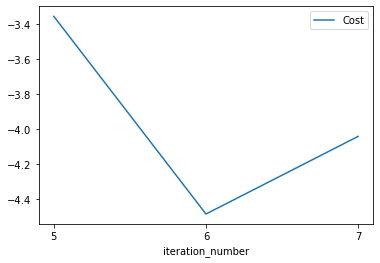

In [24]:
df = pd.DataFrame(continued_job.metrics())

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
figure = df.plot(x="iteration_number", y="Cost", ax=ax)

## Summary

In this tutorial, we set up a Max-Cut problem with a random graph using Pennylane. We saved the graph to a local file and provided it as input data to our Braket Job, along with the pre-built Pennylane container image. Variables that are required for the training process and the optimizer are passed as hyperparameters. The result is retrieved after the QAOA algorithm is completed. Lastly, we demonstrated how to use checkpoints to save and load training progress of a job.